# MIA attacks on Length-of-Stay predictor, Logistic Regression
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables


In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset
from utils.model_LR import LR, create_trained_model_and_metadata


## Train the classifier
For the LR, the data should be flatten. So set the value to True for the LR model anb False for the GRU-D

In [6]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")
use_LR = True # If True, use a logistic regression model. If False, use a GRUD model.
dataset, train_indices, validation_indices, test_indices, early_stop_indices = get_mimic_dataset(path, train_frac = 0.5,
                                                                            test_frac = 0.2,
                                                                            validation_frac = 0,
                                                                            early_stop_frac = 0,
                                                                            use_LR = use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/LR_data/dataset.pkl


In [7]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                          train_indices,
                          validation_indices,
                          test_indices,
                          early_stop_indices,
                          batch_size=128)

In [8]:
n_features = dataset.x.shape[1]
print(f"Number of features: {n_features}")

model = LR(n_features)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,
                                                                               train_loader,
                                                                               test_loader,
                                                                               lr = 0.0001,
                                                                                weight_decay = 5.392,
                                                                               epochs=20)

Number of features: 7488


Training Progress: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


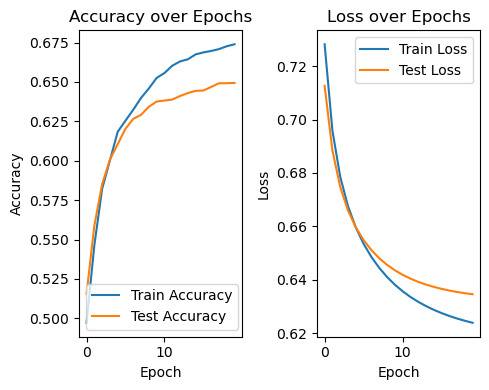

In [9]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)

Train Accuracy:  [0.4971350907011235, 0.5462736626888843, 0.5821779180080333, 0.6002033790375324, 0.6184048418034899, 0.6254595587862298, 0.6324311640668423, 0.6399112172583317, 0.6458952598115231, 0.6526077516535496, 0.655682884632273, 0.6603371399514218, 0.6630700484235236, 0.6643900579594552, 0.6675287466099922, 0.66878520047411, 0.6697092068956253, 0.6708727707254126, 0.6727012281722211, 0.673957681402247]
Test Accuracy:  [0.515514296920676, 0.5587835280518783, 0.5850993175255624, 0.6007085019036343, 0.6105769229562659, 0.6203346409295735, 0.6266131071667922, 0.6291751014558893, 0.6343149040874682, 0.6376043777716788, 0.6382211540874682, 0.6388379304032576, 0.6410994435611524, 0.6429497725085208, 0.644388917245363, 0.6445945093506261, 0.6468560225085208, 0.6492124246923547, 0.6492124246923547, 0.6494180167976179]


## Attack the LR model
Modify ```audit.yaml ``` file to attack LR model: 
  
  ```
  module_path: "utils/model_LR.py" 
  model_class: "LR"
  target_folder: "./target_LR"
  data_path: "./data/LR_data/dataset.pkl"
  ```


In [11]:
from mimic_LR_handler import MimicInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandler, config_path)

# Run the audit
leakpro.run_audit()

2025-02-17 22:31:31,265 INFO     Target model blueprint created from LR in utils/model_LR.py.
2025-02-17 22:31:31,273 INFO     Loaded target model metadata from ./target_LR/model_metadata.pkl
2025-02-17 22:31:31,274 INFO     Loaded target model from ./target_LR


2025-02-17 22:31:32,002 INFO     Loaded population dataset from ./data/LR_data/dataset.pkl
2025-02-17 22:31:32,003 INFO     Loaded population dataset from ./data/LR_data/dataset.pkl
2025-02-17 22:31:32,136 INFO     MIA attack factory loaded.
2025-02-17 22:31:32,136 INFO     Creating shadow model handler singleton
2025-02-17 22:31:32,140 INFO     Created folder ./leakpro_output/attack_objects/shadow_model
2025-02-17 22:31:32,140 INFO     Creating distillation model handler singleton
2025-02-17 22:31:32,144 INFO     Created folder ./leakpro_output/attack_objects/distillation_model
2025-02-17 22:31:32,145 INFO     Configuring RMIA attack
2025-02-17 22:31:32,145 INFO     Added attack: rmia
2025-02-17 22:31:32,146 INFO     Preparing attack: rmia
2025-02-17 22:31:32,146 INFO     Preparing shadow models for RMIA attack
2025-02-17 22:31:32,146 INFO     Preparing attack data for training the RMIA attack
2025-02-17 22:31:32,148 INFO     Check for 8 shadow models (dataset: 23944 points)
2025-02-1

<Figure size 640x480 with 0 Axes>